# Evaluation of Machine Learning Models applied to Text Sentiment Analysis

#### Source: https://www.kaggle.com/yanpapadakis/evaluation-of-nlp-models-eli5-shap



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.pipeline import Pipeline, make_pipeline



import eli5
from eli5.lime import TextExplainer

import shap

Here are the data from Quora Insincere Questions Competition

For more details follow the link: https://www.kaggle.com/c/quora-insincere-questions-classification/overview

In [2]:
# Word2Vec
from gensim.models import KeyedVectors

EMPEDDING_PATH = "../input/gensim-embeddings-dataset/"

# Load embedding
# embedding_glove = KeyedVectors.load(f"{EMPEDDING_PATH}glove.840B.300d.gensim")
embedding_google = KeyedVectors.load(f"{EMPEDDING_PATH}GoogleNews-vectors-negative300.gensim")
# embedding_paragram = KeyedVectors.load(f"{EMPEDDING_PATH}paragram_300_sl999.gensim")

In [3]:
df = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv",index_col=0)
print( df.info() )
print('\nTarget Level Counts:')
print(df.target.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 1306122 entries, 00002165364db923c7e6 to ffffed09fedb5088744a
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   question_text  1306122 non-null  object
 1   target         1306122 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 29.9+ MB
None

Target Level Counts:
0    1225312
1      80810
Name: target, dtype: int64


To get a feel of the questions at hand and of the target variable (insincere question), here are some question examples by label.

In [4]:
n_examples_by_target = 100
test_examples = df.groupby("target").head(n_examples_by_target).sort_values(by='target')

with pd.option_context('display.max_colwidth', 400):
    for t in [0,1]:
        print("\n{} Question Examples\n".format(['Sincere','Insincere'][t]))
        for q in test_examples.loc[test_examples.target==t,'question_text'].iloc[:10]:
            print(q)


Sincere Question Examples

How did Quebec nationalists see their province as a nation in the 1960s?
Do web developer refer to W3C standard practice?
How do I work in cybersecurity overseas?
What are the characteristics that define isovolumetric relaxation?
Why doesn't eBay allow the sale of WWII purple heart medals even though they have categories specifically for WWII military medals?
How do I send large picture files through an email?
What is China's new chick?
How can I get cheap flights in Edinburgh?
What are the biggest problems, questions, doubts that you come across when trying to choose the paint color for a room?
What are the theories in critical thinking?

Insincere Question Examples

Why does everyone assume the NFL kneelers have a right to free speech? That right is not protected by employees from employers by 1st amendment.
Are there really enough fragments of the True Cross to fill a whole lumberyard? Or is that another myth propagated by atheists and Catholic-bashers?
W

# Develop Text Processing Pipeline

In [5]:
max_features = 5000 # Max Number of Words / NGrams to Consider
n_docs = 300000 # Number of Documents for Development and Validation
class_names = ['sincere','insincere']

In [6]:
# Vectorizer Definition and Parameters
# Parameter choices have significant impact and need to be optimized

vectorizer = TfidfVectorizer(min_df=10, max_df=0.1, max_features=max_features)

In [7]:
# GB Classifier Definition and Parameters
# Again parameter choices are very important. They impact model performance and computational cost/time.

clf = GradientBoostingClassifier(n_estimators=100, max_depth=6, subsample=0.7, random_state=21)

The data is too big for the available computational resources, so we select a subset for development and validation.

In [8]:
np.random.seed(2021)
idx = np.random.choice(len(df),n_docs)
n_cut = int(n_docs*0.66)
train_idx = idx[:n_cut]
test_idx = idx[n_cut:]
print(len(train_idx),len(test_idx))

198000 102000


In [9]:
train_set = (df.iloc[train_idx,0].values, df.iloc[train_idx,1].values)
test_set  = (df.iloc[test_idx,0].values,  df.iloc[test_idx,1].values)

We need to be able to score documents in raw form. To make this easy we fit a pipeline that vectorizes and classifies.

In [10]:
pipe = make_pipeline(vectorizer, clf)

pipe.fit(*train_set)
pipe.score(*test_set)

0.9463921568627451

Fit is good, but not as good as what we get with DL models. See also F1_Score below.

#### Vectorizer Parameters

Some were selected before, others get default values.

In [11]:
pipe[0].get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.1,
 'max_features': 5000,
 'min_df': 10,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [12]:
features = vectorizer.get_feature_names()

**Words With High TFIDF Sum**

In [13]:
X = vectorizer.transform(test_set[0])
print(*sorted([w for w,x in zip(features,np.ravel(X.sum(0))) if x > 200]))

2017 about after all am an any anyone as at back bad be become been before being best better between book books business but buy by change china college company could country day did difference different does don during engineering english even ever examples experience feel find first free from get getting girl give go good had happen has have having he help her high his if important india indian into its job just know language learn life like live long look love made make many me mean men money more most much my name need new no not now number old on one online only or other our out over own people person possible quora real really right same say school science see sex should so some someone start still stop student study system take than that their them there they thing things think this time trump two university up us use used using want was water way ways we were when where which while white who will with without women work world would year years your


Note prevalence of India, Indians, 2017, Trump, Quora. These words capture the period (2017, Trump), an overrepresented demographic group (Indians), and words specific to this application (Quora). Naturally, we expect that as time goes by some of these words will lose their value as predictors and other might gain additional importance (e.g., Quora, Quorans).

#### Classifier Fit Evaluation

In [14]:
#pd.Series(clf.oob_improvement_).plot(figsize=(12,7),drawstyle="steps");

The model converged in 100 steps, reaching low error values after 30 rounds. Observe, the jump in the first step. The first tree in the ensemble captures about 40% of the explanatory power of the full ensemble.

Our focus here is on ML model evaluation, so this model is not optimized. A different modeling strategy, restricting tree depth to a low value (i.e. permitting only shallow trees in the ensemble) might have resulted in a better fit, but the first tree would not capture as much from the essence of the ensemble.

In [15]:
y_pred = pipe.predict_proba(df.iloc[test_idx,0].values)[:,1] > 0.06
print(classification_report(df.iloc[test_idx,1].values, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     95572
           1       0.29      0.77      0.42      6428

    accuracy                           0.87    102000
   macro avg       0.64      0.82      0.67    102000
weighted avg       0.94      0.87      0.89    102000



The performance is relatively good, but DL models, as mentioned earlier, have better performance and in particular better F1-score. The objective in this competition is to optimize the F1-score and the winners used DL models.

## Feature Importance

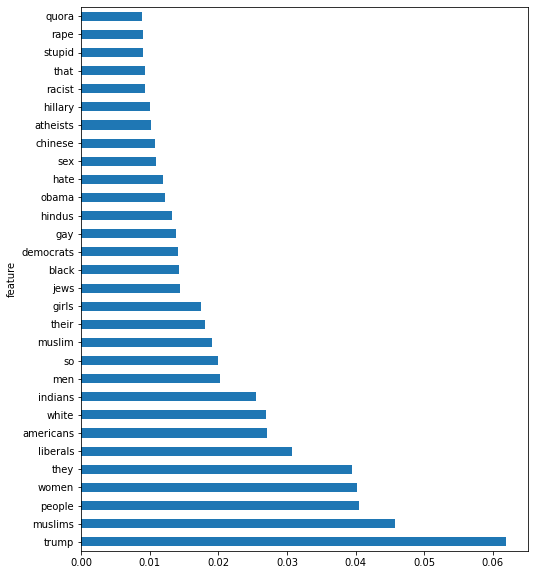

In [16]:
(
    pd.DataFrame({
        'feature': features,
        'importance': clf.feature_importances_,
    })
    .sort_values('importance', ascending=False)
).iloc[:30].set_index('feature')['importance'].plot.barh(figsize=(8,10));

We observe that "loaded" words, e.g. "Trump," "muslims," "gay," tend to top the list of most prevalent terms in the tree ensemble. We will remark in a following section below that other words, e.g. mathematical or scientific terminology, tend to be associated with sincere questions. The latter, though, are not at the top of the feature importance list.

## Overview of First Tree

It carries the most predictive power, close to half the one obtained by the full ensemble.

Some prior exposure to Decision Trees permits us to understand how many terms combine to produce insincere questions. For instance, the combination of women-white-get leads to one of the highlighted in deep orange leafs below. A combination of muslims with south leads to a negative logit and therefore lower likelihood for a question with insincere label. This is the power of analyzing the first tree in an ensemble, if tree complexity is not too high (in this case max tree depth is 6). In contrast, all other methods below are not well suited to evaluate interactions of model drivers.

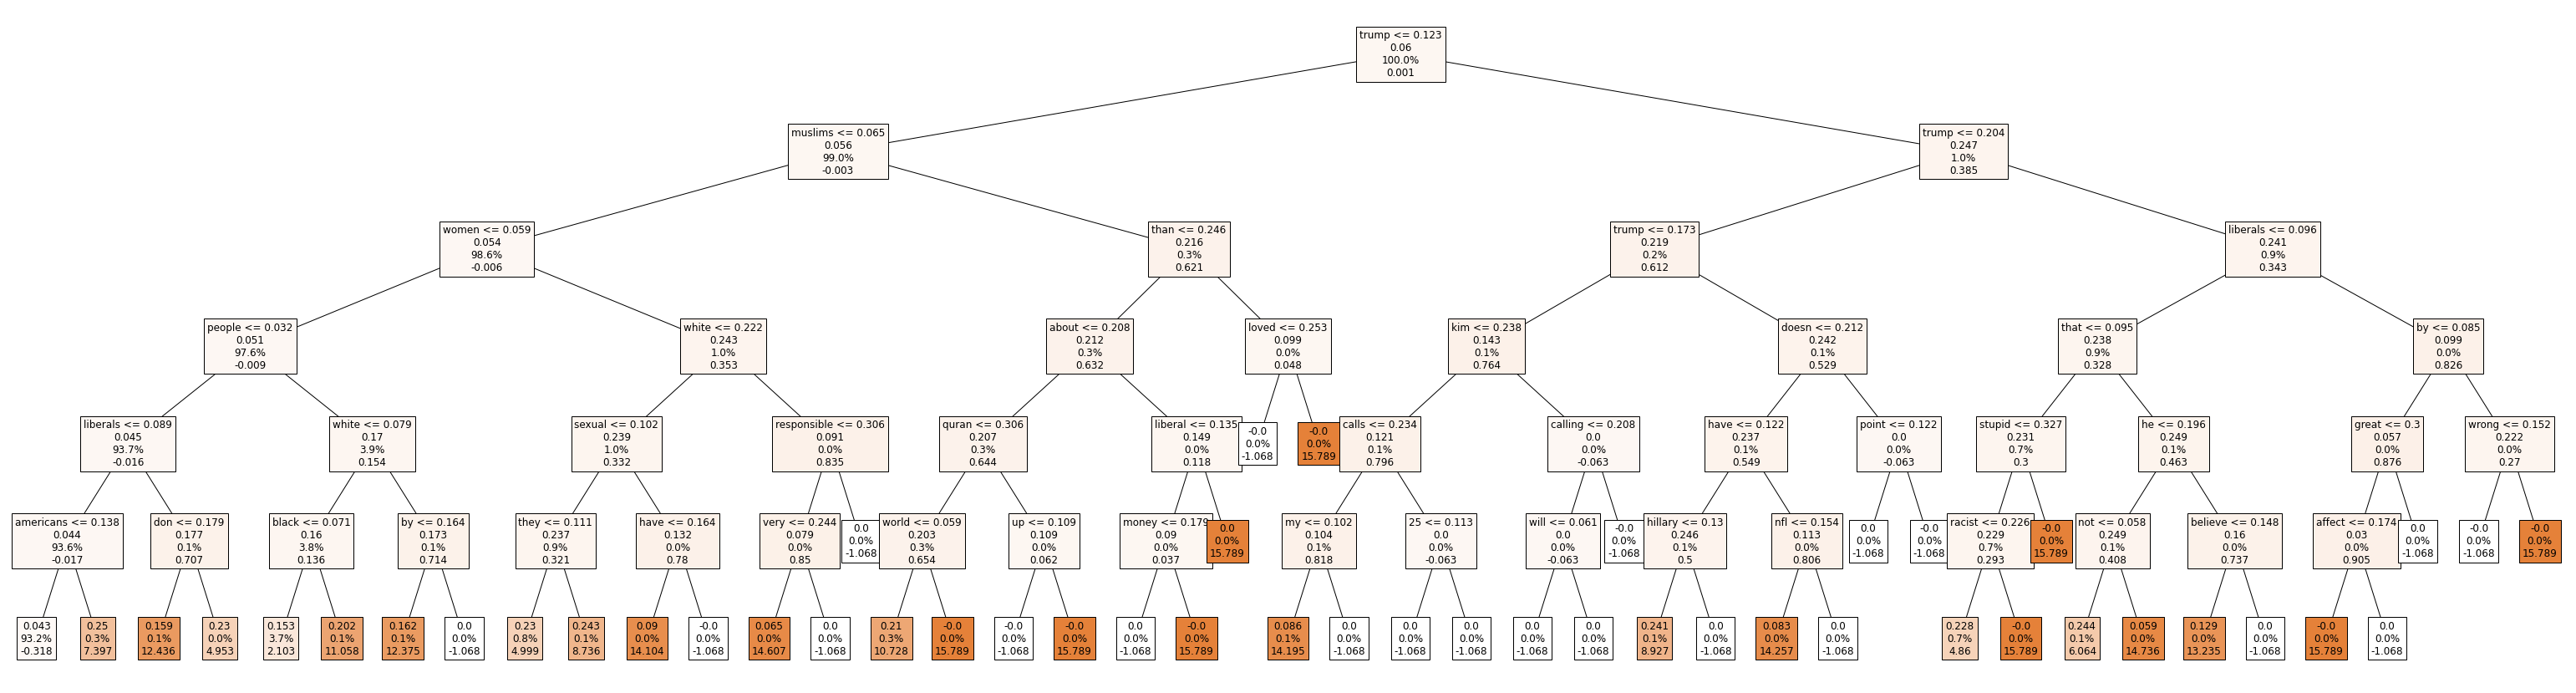

In [17]:
plt.figure(figsize=(55,15))
tree.plot_tree(clf.estimators_[0][0],fontsize=12,filled=True, feature_names=features, label=None, proportion=True);

In [18]:
#print(tree.export_text(clf.estimators_[0][0], feature_names=features))

# Model Evaluation and Transparency

We focus on the examples we selected randomly earlier and pick cases that were misclassified by our model as well as some that were correctly classified. We try to develop insights about our model by examining these examples in detail. For consistentcy, the same examples will be analyzed below using the model transparency utilities Eli5 and Shap.

In [19]:
ex_score = pipe.predict_proba(test_examples.question_text.values)[:,1]
pd.Series(ex_score).describe()

count    200.000000
mean       0.154895
std        0.205329
min        0.027031
25%        0.029393
50%        0.044819
75%        0.220891
max        0.994153
dtype: float64

In [20]:
ex_sincere   = sorted(["{:.3f}|{:3d}".format(s,i) for i, s in enumerate(ex_score[:n_examples_by_target])], reverse=True)
ex_insincere = sorted( "{:.3f}|{:3d}".format(s,i) for i, s in enumerate(ex_score[n_examples_by_target:],start=100))
# print('Sincere Examples')
# print(" With relatively high probability of being insincere")
# print(*ex_sincere[:5],sep="\n")
# print(" Correctly estimated")
# print(*ex_sincere[-5:],sep="\n")
# print('\n\nInsincere Examples')
# print(" Incorrectly estimated")
# print(*ex_insincere[:5],sep="\n")
# print(" Correctly estimated")
# print(*ex_insincere[-5:],sep="\n")

In [21]:
exid = [65, 51, 41, 103, 104, 140]

In [22]:
# Preprocess and Tokenize Just as in Development Time
vpre = vectorizer.build_preprocessor()
vtok = vectorizer.build_tokenizer()

**FI Color Scale**

Words not in model are not highlighted

In [23]:
#pd.Series(np.cumsum(sorted(clf.feature_importances_))).plot(figsize=(12,7),drawstyle="steps",grid=True,title="Feature Importance Cumulative Sum");

In [24]:
word_fi = clf.feature_importances_[clf.feature_importances_>1e-3]
print("Top {:3d} Words Capture {:5.1%} of Feature Importance".format(len(word_fi), word_fi.sum()))
word_fi2 = word_fi[word_fi>0.5e-2]
print("Top {:3d} Words Capture {:5.1%} of Feature Importance".format(len(word_fi2), word_fi2.sum()))

Top 140 Words Capture 88.5% of Feature Importance
Top  38 Words Capture 66.6% of Feature Importance


Note that only 140 out of 5,000 words capture 88.5% of total feature importance. 38 words capture 2/3 of feature importance.

In [25]:
fi_bins = [0,1e-3,5e-3,1e-2,1]
fid = np.digitize(clf.feature_importances_, fi_bins) - 1
fi_intensity = {w:k for k,w in zip(fid,features)}

In [26]:
def fi_word_color(w,i):
    # grey, yellow, magenta, red
    cmap = [97, 93, 95, 91]
    return f'\033[{cmap[i]};4m' + w + '\033[0m'

for i, x in enumerate(zip(fi_bins,fi_bins[1:])):
    print( fi_word_color("FI from {:.4f} to {:.4f}".format(*x),i) )

FI from 0.0000 to 0.0010
FI from 0.0010 to 0.0050
FI from 0.0050 to 0.0100
FI from 0.0100 to 1.0000


In [27]:
def doc_highlight(doc,fn,intensity):
    tokens = vtok(vpre(doc))
    out = []
    for w in tokens:
        out.append( fn(w, intensity[w]) if w in intensity else w)
    return ' '.join(out)

#### Highlight Documents Using Feature Importance

In [28]:
for id in exid:
    print("True Class:",class_names[test_examples.target[id]],"Score={:.4f}".format(ex_score[id]))
    print(doc_highlight(test_examples.question_text.values[id],fi_word_color,fi_intensity))
    print()

True Class: sincere Score=0.3597
is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved completely disregarding their feelings lives so you get to have something go your way and feel temporarily at ease how did things change

True Class: sincere Score=0.2576
how many indians are in melbourne australia

True Class: sincere Score=0.0270
what are some best college for aircraft propulsion

True Class: insincere Score=0.0294
what is the most degrading way to insult grammar obsessed overweight misfit homeschooled bimbo

True Class: insincere Score=0.0294
would it be possible to create better and bigger version of auschwitz with giant incinerators rather than gas chambers

True Class: insincere Score=0.9942
when will americans recognize that southern conservatives those who whine about obama jim crow appreciators are the biggest problem with america and that nothing will get solved until they are put in their place



Red words tend to be the biggest drivers as far as our fitted model is concerned. 

- In the second question, "indians" animates our model giving this question higher probability than it deserves.

- In the fourth question, the word "most" is surprisingly the most meaningful by our model. The string of insults "overweight misfit homeschooled bimbo" is not even underlined, as these terms do not even belong to the model vocabulary of top 5,000 words. Looking at this, a modeling strategy that naturally suggests itself is to increase our model's vocabulary by enhancing the development sample and our investment in computational resources.

**Probability Insincere Color Scale**

Words not in model are not highlighted

In [29]:
p_num = pipe.predict_proba([''])[0][1] # Use as numeraire the probability insincere associated with any UNKNOWN word if taken in isolation
pi_bins = [0,p_num,2*p_num,3*p_num,4*p_num,1]
pid = np.digitize(pipe.predict_proba(features)[:,1], pi_bins) - 1
pi_intensity = {w:k for k,w in zip(pid,features)}

In [30]:
def pi_word_color(w,i):
    # grey, yellow, magenta, red
    cmap = [42,46,47,43,41]
    return f'\x1b[5;39;{cmap[i]}m' + w + '\x1b[0m'

for i, x in enumerate(zip(pi_bins,pi_bins[1:])):
    print( pi_word_color("FI from {:.4f} to {:.4f}".format(*x),i) )

FI from 0.0000 to 0.0294
FI from 0.0294 to 0.0588
FI from 0.0588 to 0.0882
FI from 0.0882 to 0.1176
FI from 0.1176 to 1.0000


#### Highlight Documents Using Invidual Word Probability

In [31]:
for id in exid:
    print("True Class:",class_names[test_examples.target[id]],"Score={:.4f}".format(ex_score[id]))
    print(doc_highlight(test_examples.question_text.values[id],pi_word_color,pi_intensity))
    print()

True Class: sincere Score=0.3597
is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved completely disregarding their feelings lives so you get to have something go your way and feel temporarily at ease how did things change

True Class: sincere Score=0.2576
how many indians are in melbourne australia

True Class: sincere Score=0.0270
what are some best college for aircraft propulsion

True Class: insincere Score=0.0294
what is the most degrading way to insult grammar obsessed overweight misfit homeschooled bimbo

True Class: insincere Score=0.0294
would it be possible to create better and bigger version of auschwitz with giant incinerators rather than gas chambers

True Class: insincere Score=0.9942
when will americans recognize that southern conservatives those who whine about obama jim crow appreciators are the biggest problem with america and that nothing will get solved until they are put in their place



In some questions we see emerging patterns using this analysis:

- Question 2: Teal words combined with a red word ("indians") result in higher probability insincere for the question as a whole

- Question 3: Teal words combined with a green word, carrying positive meaning by our model ("best"), result in low probability insincere for the question as a whole

- Questions 4 & 5: many teal words without accompanying red/yellow words result in undeservedly low probability insincere for the question as a whole.

Both pictures (feature importance highlighting and probability highlighting) provide some helpful insights, but fail to provide insights about how drivers interact to increase or reduce the likelihood of a question being labeled insincere.

## 1. ELI5 

### TextExplainer

In [32]:
for id in exid:
    doc = test_examples.question_text.values[id]
    print("True Class:",class_names[test_examples.target[id]],"Score={:.4f}".format(ex_score[id]))
    te = TextExplainer(random_state=42)
    te.fit(doc, pipe.predict_proba)
    display(te.show_prediction(target_names=class_names))

True Class: sincere Score=0.3597


True Class: sincere Score=0.2576


True Class: sincere Score=0.0270


True Class: insincere Score=0.0294


True Class: insincere Score=0.0294


True Class: insincere Score=0.9942


**These examples provide some interested insights:**

- First Question, "Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. how did things change?", is labeled "sincere" but prob insincere is 36%. It seems that the given label is arbitrary, so this analysis does help to debug the model and the data collection process.

- Third Question, "what are some best college for aircraft propulsion(m.s)?", here the words "college," "aircraft," and "propulsion" appear to help the model classify the question correctly as sincere. Unfortunately, the word "propulsion" is not in the vocabulary of vectorized terms (it is coded as unknown word).

- Fourth Question, "what is the most degrading way to insult a grammar obsessed overweight misfit homeschooled bimbo?". Looking at the text explainer one observes that the words 'way," "grammar," and "overweight," have a stronger effect than "obsessed bimbo" and result in the question being misclassified as "sincere". Many of these words (e.g., "degrading," "bimbo"), though, have no relation to our model and they do not belong to the vocabulary of vectorized words.

**Overall**

This tool creates its own default model and does not explain the model we developed.

#### Eli5 Feature Importance

In [33]:
x_res = vectorizer.transform(test_examples.question_text.values)
y_res = test_examples.target.values

In [34]:
eli5.show_weights(clf, feature_names = features, top=50)

Weight,Feature
0.0620 ± 0.1048,trump
0.0458 ± 0.0839,muslims
0.0405 ± 0.0803,people
0.0401 ± 0.0838,women
0.0395 ± 0.0828,they
0.0307 ± 0.0770,liberals
0.0271 ± 0.0742,americans
0.0269 ± 0.0688,white
0.0254 ± 0.0825,indians
0.0202 ± 0.0717,men


This tool is useful but seems to provide the same results with feature importance at a significantly higher computational cost. 

To be fair Eli5 tries to provide insights even when model methodology is unknown.

An additional metric "permuation importance" has very high computational cost and we didn't evaluate it here.

# SHAP Analysis

In [35]:
x_res = vectorizer.transform(test_examples.question_text.values)
x_res_df = pd.DataFrame(x_res.todense(), columns = features)

explainer = shap.Explainer(clf)

shap_values = explainer(x_res_df)

In [36]:
shap.initjs()

for id in exid:
    print("True Class:",class_names[test_examples.target[id]],"Score={:.4f}".format(ex_score[id]))
    print(test_examples.iloc[id,0])
    display(shap.plots.force(shap_values[id], feature_names=features))

True Class: sincere Score=0.3597
Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. How did things change?


True Class: sincere Score=0.2576
How many Indians are in Melbourne, Australia?


True Class: sincere Score=0.0270
What are some best college for aircraft propulsion(M.S)?


True Class: insincere Score=0.0294
What is the most degrading way to insult a grammar obsessed overweight misfit homeschooled bimbo?


True Class: insincere Score=0.0294
Would it be possible to create a better and bigger version of Auschwitz with giant incinerators rather than gas chambers?


True Class: insincere Score=0.9942
When will Americans recognize that southern conservatives (those who whine about Obama, Jim Crow appreciators) are the biggest problem with America and that nothing will get solved until they are put in their place?


Interesting graph, but the weights of each word in a sentence (Shapley values) appear arbitrary. Again, they seem to capture the sum of individual effects and not the effect of word interactions.

#### Shap's Alternatives of Feature Importance

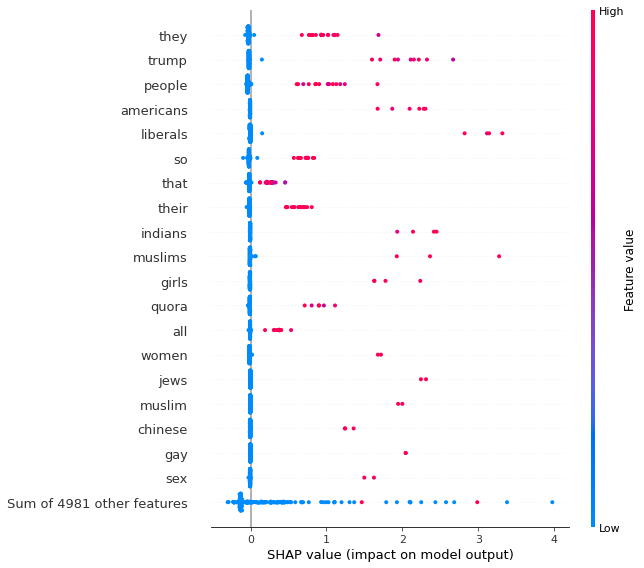

In [37]:
shap.initjs()
shap.plots.beeswarm(shap_values,20)

This graph appears to capture the terms at the top of the feature importance list. Hence, it is useful. But, complex calculations need to take place to obtain this graph.

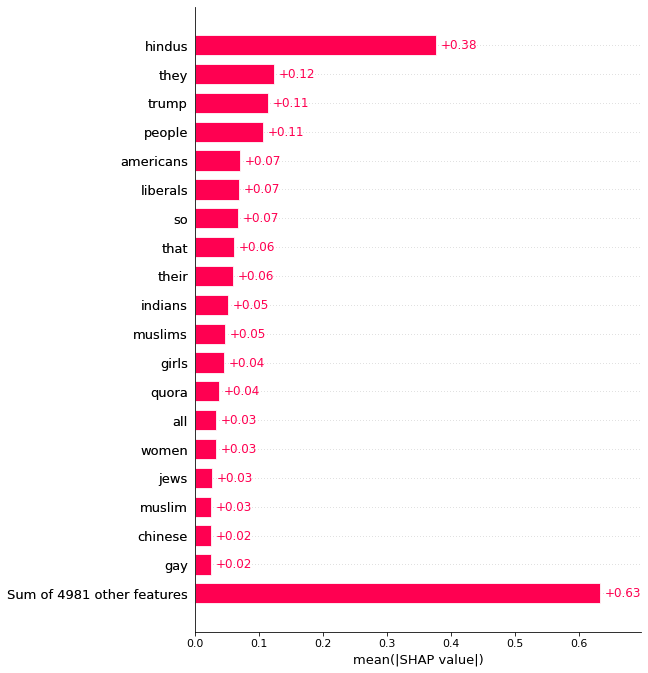

In [38]:
shap.plots.bar(shap_values, 20)

This graph is an alternative view of the beeswarm plot.

In [39]:
#shap.decision_plot(explainer.expected_value, shap_values.values, features, link='logit')

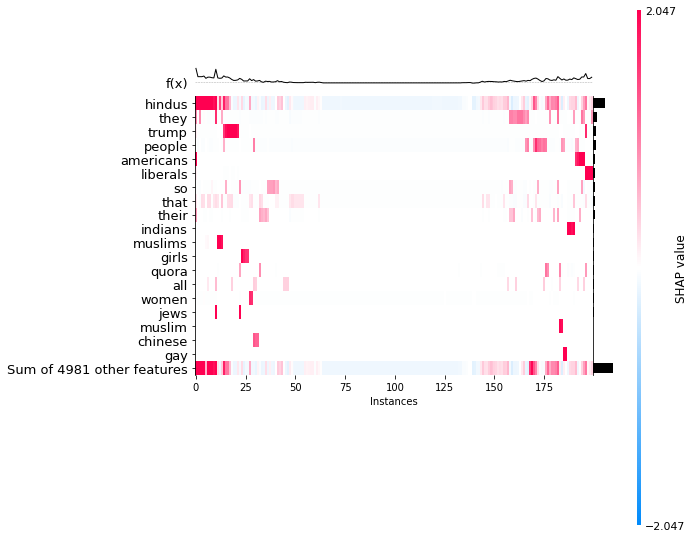

In [40]:
shap.plots.heatmap(shap_values, max_display = 20)

## LIME

In [41]:
idx = 140

In [42]:
test_examples['question_text'][0]

'How did Quebec nationalists see their province as a nation in the 1960s?'

In [43]:
import lime

import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
import sklearn.metrics
#from __future__ import print_function

import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_20newsgroups

from lime import lime_text

from lime.lime_text import LimeTextExplainer


In [44]:
idx = 140

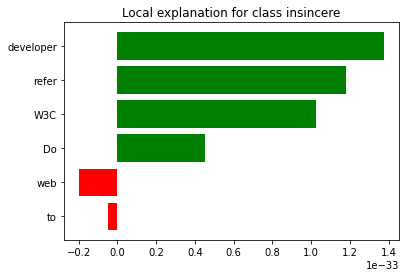

In [45]:
explainer = LimeTextExplainer(class_names=class_names)

exp = explainer.explain_instance(test_examples['question_text'][1], pipe.predict_proba, num_features=6) 
   
fig = exp.as_pyplot_figure()

In [46]:
exp.show_in_notebook(text=True)

## X-Why

In [47]:
from functools import partial
import itertools
import json
import re

import numpy as np
import scipy as sp
import sklearn
from sklearn.utils import check_random_state
from sklearn.linear_model import Ridge, lars_path

# from lime import explanation


# from lime import lime_base

from io import open
import os
import os.path
import json
import string
import numpy as np

class LimeError(Exception):
    """Raise for errors"""

from sklearn.utils import check_random_state

import sys

sys.path.insert(1, "../input/lime2test2")

import explanation
import lime_base

from lime_base import LimeBase


class TextDomainMapper(explanation.DomainMapper):
    """Maps feature ids to words or word-positions"""

    def __init__(self, indexed_string):
        """Initializer.
        Args:
            indexed_string: lime_text.IndexedString, original string
        """
        self.indexed_string = indexed_string

    def map_exp_ids(self, exp, positions=False):
        """Maps ids to words or word-position strings.
        Args:
            exp: list of tuples [(id, weight), (id,weight)]
            positions: if True, also return word positions
        Returns:
            list of tuples (word, weight), or (word_positions, weight) if
            examples: ('bad', 1) or ('bad_3-6-12', 1)
        """
        if positions:
            exp = [('%s_%s' % (
                self.indexed_string.word(x[0]),
                '-'.join(
                    map(str,
                        self.indexed_string.string_position(x[0])))), x[1])
                   for x in exp]
        else:
            exp = [(self.indexed_string.word(x[0]), x[1]) for x in exp]
        return exp

    def visualize_instance_html(self, exp, label, div_name, exp_object_name,
                                text=True, opacity=True):
        """Adds text with highlighted words to visualization.
        Args:
             exp: list of tuples [(id, weight), (id,weight)]
             label: label id (integer)
             div_name: name of div object to be used for rendering(in js)
             exp_object_name: name of js explanation object
             text: if False, return empty
             opacity: if True, fade colors according to weight
        """
        if not text:
            return u''
        text = (self.indexed_string.raw_string()
                .encode('utf-8', 'xmlcharrefreplace').decode('utf-8'))
        text = re.sub(r'[<>&]', '|', text)
        exp = [(self.indexed_string.word(x[0]),
                self.indexed_string.string_position(x[0]),
                x[1]) for x in exp]
        all_occurrences = list(itertools.chain.from_iterable(
            [itertools.product([x[0]], x[1], [x[2]]) for x in exp]))
        all_occurrences = [(x[0], int(x[1]), x[2]) for x in all_occurrences]
        ret = '''
            %s.show_raw_text(%s, %d, %s, %s, %s);
            ''' % (exp_object_name, json.dumps(all_occurrences), label,
                   json.dumps(text), div_name, json.dumps(opacity))
        return ret


class IndexedString(object):
    """String with various indexes."""

    def __init__(self, raw_string, split_expression=r'\W+', bow=True,
                 mask_string=None):
        """Initializer.
        Args:
            raw_string: string with raw text in it
            split_expression: Regex string or callable. If regex string, will be used with re.split.
                If callable, the function should return a list of tokens.
            bow: if True, a word is the same everywhere in the text - i.e. we
                 will index multiple occurrences of the same word. If False,
                 order matters, so that the same word will have different ids
                 according to position.
            mask_string: If not None, replace words with this if bow=False
                if None, default value is UNKWORDZ
        """
        self.raw = raw_string
        self.mask_string = 'UNKWORDZ' if mask_string is None else mask_string

        if callable(split_expression):
            tokens = split_expression(self.raw)
            self.as_list = self._segment_with_tokens(self.raw, tokens)
            tokens = set(tokens)

            def non_word(string):
                return string not in tokens

        else:
            # with the split_expression as a non-capturing group (?:), we don't need to filter out
            # the separator character from the split results.
            splitter = re.compile(r'(%s)|$' % split_expression)
            self.as_list = [s for s in splitter.split(self.raw) if s]
            non_word = splitter.match

        self.as_np = np.array(self.as_list)
        self.string_start = np.hstack(
            ([0], np.cumsum([len(x) for x in self.as_np[:-1]])))
        vocab = {}
        self.inverse_vocab = []
        self.positions = []
        self.bow = bow
        non_vocab = set()
        for i, word in enumerate(self.as_np):
            if word in non_vocab:
                continue
            if non_word(word):
                non_vocab.add(word)
                continue
            if bow:
                if word not in vocab:
                    vocab[word] = len(vocab)
                    self.inverse_vocab.append(word)
                    self.positions.append([])
                idx_word = vocab[word]
                self.positions[idx_word].append(i)
            else:
                self.inverse_vocab.append(word)
                self.positions.append(i)
        if not bow:
            self.positions = np.array(self.positions)

    def raw_string(self):
        """Returns the original raw string"""
        return self.raw

    def num_words(self):
        """Returns the number of tokens in the vocabulary for this document."""
        return len(self.inverse_vocab)

    def word(self, id_):
        """Returns the word that corresponds to id_ (int)"""
        return self.inverse_vocab[id_]

    def string_position(self, id_):
        """Returns a np array with indices to id_ (int) occurrences"""
        if self.bow:
            return self.string_start[self.positions[id_]]
        else:
            return self.string_start[[self.positions[id_]]]

    def inverse_removing(self, words_to_remove):
        """Returns a string after removing the appropriate words.
        If self.bow is false, replaces word with UNKWORDZ instead of removing
        it.
        Args:
            words_to_remove: list of ids (ints) to remove
        Returns:
            original raw string with appropriate words removed.
        """
        mask = np.ones(self.as_np.shape[0], dtype='bool')
        mask[self.__get_idxs(words_to_remove)] = False
        if not self.bow:
            return ''.join(
                [self.as_list[i] if mask[i] else self.mask_string
                 for i in range(mask.shape[0])])
        return ''.join([self.as_list[v] for v in mask.nonzero()[0]])

    @staticmethod
    def _segment_with_tokens(text, tokens):
        """Segment a string around the tokens created by a passed-in tokenizer"""
        list_form = []
        text_ptr = 0
        for token in tokens:
            inter_token_string = []
            while not text[text_ptr:].startswith(token):
                inter_token_string.append(text[text_ptr])
                text_ptr += 1
                if text_ptr >= len(text):
                    raise ValueError("Tokenization produced tokens that do not belong in string!")
            text_ptr += len(token)
            if inter_token_string:
                list_form.append(''.join(inter_token_string))
            list_form.append(token)
        if text_ptr < len(text):
            list_form.append(text[text_ptr:])
        return list_form

    def __get_idxs(self, words):
        """Returns indexes to appropriate words."""
        if self.bow:
            return list(itertools.chain.from_iterable(
                [self.positions[z] for z in words]))
        else:
            return self.positions[words]


class IndexedCharacters(object):
    """String with various indexes."""

    def __init__(self, raw_string, bow=True, mask_string=None):
        """Initializer.
        Args:
            raw_string: string with raw text in it
            bow: if True, a char is the same everywhere in the text - i.e. we
                 will index multiple occurrences of the same character. If False,
                 order matters, so that the same word will have different ids
                 according to position.
            mask_string: If not None, replace characters with this if bow=False
                if None, default value is chr(0)
        """
        self.raw = raw_string
        self.as_list = list(self.raw)
        self.as_np = np.array(self.as_list)
        self.mask_string = chr(0) if mask_string is None else mask_string
        self.string_start = np.arange(len(self.raw))
        vocab = {}
        self.inverse_vocab = []
        self.positions = []
        self.bow = bow
        non_vocab = set()
        for i, char in enumerate(self.as_np):
            if char in non_vocab:
                continue
            if bow:
                if char not in vocab:
                    vocab[char] = len(vocab)
                    self.inverse_vocab.append(char)
                    self.positions.append([])
                idx_char = vocab[char]
                self.positions[idx_char].append(i)
            else:
                self.inverse_vocab.append(char)
                self.positions.append(i)
        if not bow:
            self.positions = np.array(self.positions)

    def raw_string(self):
        """Returns the original raw string"""
        return self.raw

    def num_words(self):
        """Returns the number of tokens in the vocabulary for this document."""
        return len(self.inverse_vocab)

    def word(self, id_):
        """Returns the word that corresponds to id_ (int)"""
        return self.inverse_vocab[id_]

    def string_position(self, id_):
        """Returns a np array with indices to id_ (int) occurrences"""
        if self.bow:
            return self.string_start[self.positions[id_]]
        else:
            return self.string_start[[self.positions[id_]]]

    def inverse_removing(self, words_to_remove):
        """Returns a string after removing the appropriate words.
        If self.bow is false, replaces word with UNKWORDZ instead of removing
        it.
        Args:
            words_to_remove: list of ids (ints) to remove
        Returns:
            original raw string with appropriate words removed.
        """
        mask = np.ones(self.as_np.shape[0], dtype='bool')
        mask[self.__get_idxs(words_to_remove)] = False
        if not self.bow:
            return ''.join(
                [self.as_list[i] if mask[i] else self.mask_string
                 for i in range(mask.shape[0])])
        return ''.join([self.as_list[v] for v in mask.nonzero()[0]])

    def __get_idxs(self, words):
        """Returns indexes to appropriate words."""
        if self.bow:
            return list(itertools.chain.from_iterable(
                [self.positions[z] for z in words]))
        else:
            return self.positions[words]


class LimeTextExplainer2(object):
    """Explains text classifiers.
       Currently, we are using an exponential kernel on cosine distance, and
       restricting explanations to words that are present in documents."""

    def __init__(self,
                 kernel_width=25,
                 kernel=None,
                 verbose=False,
                 class_names=None,
                 feature_selection='auto',
                 split_expression=r'\W+',
                 bow=True,
                 mask_string=None,
                 random_state=None,
                 char_level=False):
        """Init function.
        Args:
            kernel_width: kernel width for the exponential kernel.
            kernel: similarity kernel that takes euclidean distances and kernel
                width as input and outputs weights in (0,1). If None, defaults to
                an exponential kernel.
            verbose: if true, print local prediction values from linear model
            class_names: list of class names, ordered according to whatever the
                classifier is using. If not present, class names will be '0',
                '1', ...
            feature_selection: feature selection method. can be
                'forward_selection', 'lasso_path', 'none' or 'auto'.
                See function 'explain_instance_with_data' in lime_base.py for
                details on what each of the options does.
            split_expression: Regex string or callable. If regex string, will be used with re.split.
                If callable, the function should return a list of tokens.
            bow: if True (bag of words), will perturb input data by removing
                all occurrences of individual words or characters.
                Explanations will be in terms of these words. Otherwise, will
                explain in terms of word-positions, so that a word may be
                important the first time it appears and unimportant the second.
                Only set to false if the classifier uses word order in some way
                (bigrams, etc), or if you set char_level=True.
            mask_string: String used to mask tokens or characters if bow=False
                if None, will be 'UNKWORDZ' if char_level=False, chr(0)
                otherwise.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
            char_level: an boolean identifying that we treat each character
                as an independent occurence in the string
        """

        if kernel is None:
            def kernel(d, kernel_width):
                eps = 1
                return np.sqrt(np.exp(-((eps*d) ** 2) / kernel_width ** 2))

        kernel_fn = partial(kernel, kernel_width=kernel_width)

        self.random_state = check_random_state(random_state)
        self.base = LimeBase(kernel_fn, verbose,
                                       random_state=self.random_state)
        self.class_names = class_names
        self.vocabulary = None
        self.feature_selection = feature_selection
        self.bow = bow
        self.mask_string = mask_string
        self.split_expression = split_expression
        self.char_level = char_level

    def explain_instance(self,
                         text_instance,
                         classifier_fn,
                         labels=(1,),
                         top_labels=None,
                         num_features=10,
                         num_samples=1000,
                         distance_metric='cosine',
                         model_regressor=None):
        """Generates explanations for a prediction.
        First, we generate neighborhood data by randomly hiding features from
        the instance (see __data_labels_distance_mapping). We then learn
        locally weighted linear models on this neighborhood data to explain
        each of the classes in an interpretable way (see lime_base.py).
        Args:
            text_instance: raw text string to be explained.
            classifier_fn: classifier prediction probability function, which
                takes a list of d strings and outputs a (d, k) numpy array with
                prediction probabilities, where k is the number of classes.
                For ScikitClassifiers , this is classifier.predict_proba.
            labels: iterable with labels to be explained.
            top_labels: if not None, ignore labels and produce explanations for
                the K labels with highest prediction probabilities, where K is
                this parameter.
            num_features: maximum number of features present in explanation
            num_samples: size of the neighborhood to learn the linear model
            distance_metric: the distance metric to use for sample weighting,
                defaults to cosine similarity
            model_regressor: sklearn regressor to use in explanation. Defaults
            to Ridge regression in LimeBase. Must have model_regressor.coef_
            and 'sample_weight' as a parameter to model_regressor.fit()
        Returns:
            An Explanation object (see explanation.py) with the corresponding
            explanations.
        """

        indexed_string = (IndexedCharacters(
            text_instance, bow=self.bow, mask_string=self.mask_string)
                          if self.char_level else
                          IndexedString(text_instance, bow=self.bow,
                                        split_expression=self.split_expression,
                                        mask_string=self.mask_string))
        domain_mapper = TextDomainMapper(indexed_string)
        data, yss, distances = self.__data_labels_distances(
            indexed_string, classifier_fn, num_samples,
            distance_metric=distance_metric)
        if self.class_names is None:
            self.class_names = [str(x) for x in range(yss[0].shape[0])]
        ret_exp = explanation.Explanation(domain_mapper=domain_mapper,
                                          class_names=self.class_names,
                                          random_state=self.random_state)
        ret_exp.predict_proba = yss[0]
        if top_labels:
            labels = np.argsort(yss[0])[-top_labels:]
            ret_exp.top_labels = list(labels)
            ret_exp.top_labels.reverse()
        for label in labels:
            (ret_exp.intercept[label],
             ret_exp.local_exp[label],
             ret_exp.score[label],
             ret_exp.local_pred[label]) = self.base.explain_instance_with_data(
                data, yss, distances, label, num_features,
                model_regressor=model_regressor,
                feature_selection=self.feature_selection)
        return ret_exp

    def __data_labels_distances(self,
                                indexed_string,
                                classifier_fn,
                                num_samples,
                                distance_metric='cosine'):
        """Generates a neighborhood around a prediction.
        Generates neighborhood data by randomly removing words from
        the instance, and predicting with the classifier. Uses cosine distance
        to compute distances between original and perturbed instances.
        Args:
            indexed_string: document (IndexedString) to be explained,
            classifier_fn: classifier prediction probability function, which
                takes a string and outputs prediction probabilities. For
                ScikitClassifier, this is classifier.predict_proba.
            num_samples: size of the neighborhood to learn the linear model
            distance_metric: the distance metric to use for sample weighting,
                defaults to cosine similarity.
        Returns:
            A tuple (data, labels, distances), where:
                data: dense num_samples * K binary matrix, where K is the
                    number of tokens in indexed_string. The first row is the
                    original instance, and thus a row of ones.
                labels: num_samples * L matrix, where L is the number of target
                    labels
                distances: cosine distance between the original instance and
                    each perturbed instance (computed in the binary 'data'
                    matrix), times 100.
        """

        def distance_fn(x):
            return sklearn.metrics.pairwise.pairwise_distances(x, x[0], metric=distance_metric).ravel() * 100
        
        def distance_fn_wd(x):
            wmd = []
            for strha in x:
                wmd.append(embedding_google.wmdistance(strha, x[0]))
            print(len(wmd))
            return np.array(wmd).ravel() * 100
                

        doc_size = indexed_string.num_words()
        sample = self.random_state.randint(1, doc_size + 1, num_samples - 1)
        data = np.ones((num_samples, doc_size))
        data[0] = np.ones(doc_size)
        features_range = range(doc_size)
        inverse_data = [indexed_string.raw_string()]
        for i, size in enumerate(sample, start=1):
            inactive = self.random_state.choice(features_range, size,
                                                replace=False)
            data[i, inactive] = 0
            inverse_data.append(indexed_string.inverse_removing(inactive))
        labels = classifier_fn(inverse_data)
        distances2 = distance_fn(sp.sparse.csr_matrix(data))
        distances3 = distance_fn_wd(inverse_data)
        distances = distances3# + distances3
        return data, labels, distances

In [48]:
idx = 140 #65# [65, 51, 41, 103, 104, 140]

CPU times: user 1.74 s, sys: 1.05 s, total: 2.79 s
Wall time: 1.18 s


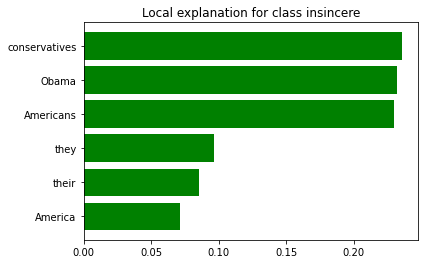

In [49]:
%%time

explainer = LimeTextExplainer(class_names=class_names)

exp = explainer.explain_instance(test_examples['question_text'][idx], pipe.predict_proba, num_features=6) 
%matplotlib inline 
fig = exp.as_pyplot_figure()

1000
When will Americans recognize that southern conservatives (those who whine about Obama, Jim Crow appreciators) are the biggest problem with America and that nothing will get solved until they are put in their place?

CPU times: user 11.7 s, sys: 1.24 s, total: 12.9 s
Wall time: 12.9 s


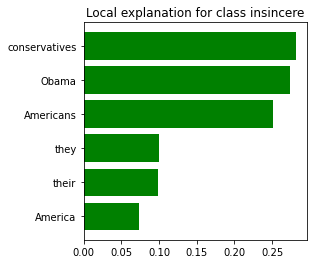

In [50]:
%%time

explainer = LimeTextExplainer2(class_names=class_names)
expnew = explainer.explain_instance(test_examples['question_text'][idx], pipe.predict_proba, num_features=6)

print(test_examples['question_text'][idx])
print('')


fig = expnew.as_pyplot_figure()

In [51]:
def read_lime(interp):
    interp.as_list()
    interp2 = interp.local_exp#.items()

    interp3 = []
    for ii, jj in interp2[1]:
        interp3.append(jj)

    interp_feats = []
    for ii in range(len(expnew.local_exp[1])):
        interp_feats.append(interp.as_list()[ii][0])

    return interp3, interp_feats

lime_coeff_new, Lime_feat_new = read_lime(expnew)
lime_coeff, Lime_feat = read_lime(exp)


from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("SMILE","LIME",))

fig.add_trace(
    go.Bar(x=lime_coeff_new, y=Lime_feat_new, orientation='h', 
           marker=dict(color=np.argsort(lime_coeff_new), coloraxis="coloraxis")),#, color=df3['feature_names']),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=lime_coeff, y=Lime_feat, orientation='h', marker=dict(color=np.argsort(lime_coeff), coloraxis="coloraxis")),
    row=1, col=2
)

fig.update_layout(height=600, width=1200, title_text="Comparing SMILE and LIME (Negative: Atheism, Positive: Christian)",
                  coloraxis=dict(colorscale='Bluered_r'), showlegend=False) # px.colors.sequential.Viridis
fig.show()

In [52]:
print("True Class:",class_names[test_examples.target[idx]],"Score={:.4f}".format(ex_score[idx]))
print(test_examples.iloc[idx,0])
display(shap.plots.force(shap_values[idx], feature_names=features))

True Class: insincere Score=0.9942
When will Americans recognize that southern conservatives (those who whine about Obama, Jim Crow appreciators) are the biggest problem with America and that nothing will get solved until they are put in their place?


['When will Americans recognize that southern conservatives (those who whine about Obama, Jim Crow appreciators) are the biggest problem with America and that nothing will get solved until they are put in their place?']


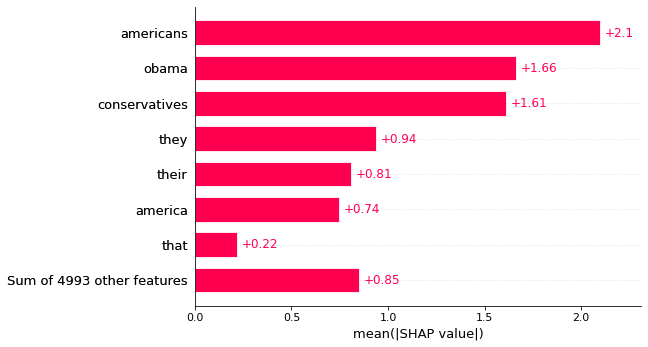

In [53]:
# idx = 65
print([test_examples.question_text[idx]])
x_res = vectorizer.transform([test_examples.question_text[idx]])
x_res_df = pd.DataFrame(x_res.todense(), columns = features)

explainer2 = shap.Explainer(clf)

shap_values2 = explainer2(x_res_df)

shap.force_plot(explainer2.expected_value, shap_values2.values)

shap.plots.bar(shap_values2, 8)

In [54]:
shap_feat_imp = np.sort(shap_values2.values)
shap_feat_imp = shap_feat_imp[0][::-1]
print(shap_feat_imp[:7])

shap_feat_imparg = np.argsort(shap_values2.values)
shap_feat_imparg = shap_feat_imparg[0][::-1]

shap_feat_names = []
for ii in shap_feat_imparg[:7]:
    shap_feat_names.append(shap_values2.feature_names[ii])
    
shap_feat_names

[2.09608848 1.66340511 1.60892518 0.93906168 0.80605125 0.74462249
 0.22075572]


['americans', 'obama', 'conservatives', 'they', 'their', 'america', 'that']

In [55]:
print("True Class:",class_names[test_examples.target[idx]],"Score={:.4f}".format(ex_score[idx]))
# print(test_examples.iloc[idx,0])

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("SMILE","LIME","SHAP"))

fig.add_trace(
    go.Bar(x=lime_coeff_new, y=Lime_feat_new, orientation='h', 
           marker=dict(color=np.argsort(lime_coeff_new), coloraxis="coloraxis")),#, color=df3['feature_names']),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=lime_coeff, y=Lime_feat, orientation='h', marker=dict(color=np.argsort(np.sort(lime_coeff)[::-1]), coloraxis="coloraxis")),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=shap_feat_imp[:7], y=shap_feat_names, orientation='h', marker=dict(color=np.argsort(shap_feat_imp[:7]), coloraxis="coloraxis")),
    row=1, col=3
)

fig.update_layout(height=600, width=1600, title_text="Comparing SMILE and LIME (Negative: Sincere, Positive: Insincere)",
                  coloraxis=dict(colorscale='Bluered_r'), showlegend=False) # px.colors.sequential.Viridis
fig.show()

True Class: insincere Score=0.9942


In [56]:
# Source: https://www.kaggle.com/naim99/innvestigate-albermax-modified
import matplotlib.pyplot as plt
from matplotlib import cm, transforms

def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr) #bwr #coolwarm #PiYG 'RdYlBu', 'RdYlGn'
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t, fontsize=14)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

In [57]:
def read_lime(interp):
    interp.as_list()
    interp2 = interp.local_exp#.items()

    interp3 = []
    for ii, jj in interp2[1]:
        interp3.append(jj)

    interp_feats = []
    for ii in range(len(expnew.local_exp[1])):
        interp_feats.append(interp.as_list()[ii][0])

    return interp3, interp_feats

In [58]:
%%time

explainer = LimeTextExplainer2(class_names=class_names)
expnew = explainer.explain_instance(test_examples['question_text'][idx], pipe.predict_proba, num_features=44)

1000
CPU times: user 10 s, sys: 80.2 ms, total: 10.1 s
Wall time: 10.1 s


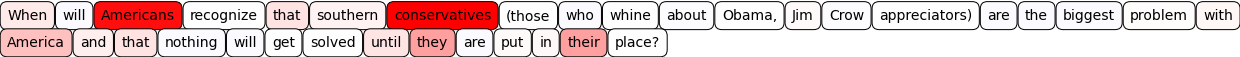

In [59]:
lime_coeff_new, Lime_feat_new = read_lime(expnew)
words2 = test_examples.question_text[idx].split(' ')
words_imp = []
for ii in words2:
    if ii not in Lime_feat_new:
        words_imp.append(0)
    else:
        words_imp.append(lime_coeff_new[Lime_feat_new.index(ii)])
    
plot_text_heatmap(words2, np.array(words_imp))